# TCLab: Model Predictive Control (MPC)

## Mathematical Model and Pyomo Simulation

Recall the two-state model for a single heater/sensor assembly:

\begin{align*}
C_p^H \frac{dT_H}{dt} & = U_a (T_{amb} - T_H) + U_b (T_S - T_H) + \alpha P u(t) + d(t)\\
C_p^S \frac{dT_S}{dt} & = - U_c (T_S - T_H) 
\end{align*}

### Pyomo Model

The code provides a library for performing several analysis tasks with our model. This is a `class`, which is a more sophisticated way to modularize our code. Briefly, classes store both data and methods to manipualte the data (as demonstrated in Lab 5).

Take a few minutes to study this code. A few features:
* It supports four modes:
  * `simulate` solve the model with all of the inputs specified (zero degrees of freedom)
  * `control` determine the best $u(t)$ to track the desired $T_{set}(t)$
  * `observe` estimate the unmeasured state $T_{H}(t)$ and disturbance $d(t)$ from experimental data
* The `__init__` method is called automatically when you create an instance of the object. The initial method is how you pass in data
* The `solve` method call the numerical optimization algorithm
* The `plot` method plots the Pyomo results
* The `get_Ts`, `get_Th`, `get_U`, and `get_D` methods return data stored in the Pyomo model after it is solved


In [1]:
# update value from code cell and run above if returning to notebook with reset kernel
Tamb = 21 # deg C

In [2]:
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np

# ensure that IDEAS is imported if there is an error calling Ipopt
import idaes

# Protip: only import the functions you need for each library.
# This tells other programs exactly where each function is defined.
# Avoid using from pyomo.environ import * as this imports everything
from pyomo.environ import ConcreteModel, Var, Param, Constraint, TransformationFactory, SolverFactory, Objective, minimize, value, Suffix
from pyomo.dae import DerivativeVar, ContinuousSet, Simulator

##### IMPORTANT #####
# Update the default values for Ua, Ub, CpH, and CpS with results from lab 3 or 5
# The values used below were taken from the open-loop optimization 
# lecture notebook ("Take Two" section)
#####################

class TCLabPyomo:
    '''
    This class contains the methods used for simulating the TCLab model, optimizing u(t) per a 
    given set point for T, and estimating state variables in the TCLab.
    '''

    def __init__(self, mode, t_data, u_data, d_data, Tset_data, 
                 TS_data, Tamb = Tamb, alpha = 0.00016, P1 = 200,
                 Ua = 0.0535, Ub = 0.0148, CpH = 6.911, CpS = 0.318,
                 obj_weight_observe=1.0, obj_weight_optimize=0.01, 
                 verbose = True, time_finite_difference = 'BACKWARD'
    ):
        '''
        This method is called automatically when instantiating class.
        It stores input data in the class and creates the pyomo model.
        
        Arguments:
            mode: specify mode
            t_data: time data
            u_data: input control data
            d_data: disturbance data
            Tset_data: set point data
            TS_data: experimental data
            Tamb: ambient temperature, deg C
            alpha: watts / (units P1 * percent U1)
            P1: max power, P1 units
            Ua: heat transfer coefficient from heater to environment, watts/deg C
            Ub: heat transfer coefficient from heater to sensor, watts/deg C
            CpH: heat capacity of the heater, joules/deg C
            CpS: heat capacity of the, joules/deg C
            obj_weight_observe: weight for disturbance in objective function, default is 0.1
            obj_weight_optimize: weight for heater temperature in objective function, default is 0.01
            verbose: Boolean to control ipopt output, default = True returns the ipopt output
            time_finite_difference: method for finite difference, 'BACKWARD' or 'FORWARD'
            
        Returns:
            None 
        '''
        
        # establish the valid operating modes
        # notice, we removed 'estimate' mode
        valid_modes = ['simulate','optimize','observe']

        # raise an error if the user feeds in invalid operating mode
        if mode not in valid_modes:
            raise ValueError("'mode' must be one of the following:"+valid_modes)

        # define mode and data
        self.mode = mode
        self.t_data = t_data
        self.u_data = u_data
        self.d_data = d_data
        self.Tset_data = Tset_data
        self.TS_data = TS_data

        # set parameter values
        self.Tamb = Tamb
        self.Ua = Ua
        self.Ub = Ub
        self.CpH = CpH
        self.CpS = CpS
        self.alphaP = alpha*P1
        self.obj_weight_observe = obj_weight_observe
        self.obj_weight_optimize = obj_weight_optimize
        self.verbose = verbose

        if time_finite_difference not in ['BACKWARD', 'FORWARD']:
            raise ValueError("'time_finite_difference' must be either 'BACKWARD' or 'FORWARD'")

        self.time_finite_difference = time_finite_difference

        # create the pyomo model
        self._create_pyomo_model()

        return None


    def _create_pyomo_model(self):
        '''
        Method that creates and defines the pyomo model for each mode.
        Arguments:
            None
        Returns:
            m: the pyomo model
        '''
        
        # create the pyomo model
        m = ConcreteModel()

        # create the time set
        m.t = ContinuousSet(initialize = self.t_data)  # make sure the experimental time grid are discretization points
        # define the heater and sensor temperatures as variables
        m.Th = Var(m.t, bounds=[0, 80], initialize=self.Tamb)
        m.Ts = Var(m.t, bounds=[0, 80], initialize=self.Tamb)

        def helper(my_array):
            '''
            Method that builds a dictionary to help initialization.
            Arguments:
                my_array: an array
            Returns:
                data: a dict {time: array_value}
            '''
            # ensure that the dimensions of array and time data match
            assert len(my_array) == len(self.t_data), "Dimension mismatch."
            data = {}
            for k,t in enumerate(self.t_data):
                data[t] = my_array[k]
            return data

        # for the simulate and observe modes
        if self.mode in ['simulate', 'observe']:
            # control decision is a parameter initialized with the input control data dict
            m.U = Param(m.t, initialize=helper(self.u_data), default = 0)
        else:
            # otherwise (optimize) control decision is a variable
            m.U = Var(m.t, bounds=(0, 100))

        # for the simulate and optimize modes
        if self.mode in ['simulate', 'optimize']:
            # if no distrubance data exists, initialize parameter at 0
            if self.d_data is None:
                 m.D = Param(m.t, default = 0)
            # otherwise initialize parameter with disturbance data dict
            else:
                m.D = Param(m.t, initialize=helper(self.d_data))
        # otherwise (observe) the disturbance is a variable
        else:
            m.D = Var(m.t)

        # define parameters that do not depend on mode
        m.Tamb = Param(initialize=self.Tamb)
        m.alphaP = Param(initialize=self.alphaP)
        # Ua, Ub, CpH, and CpS are parameters
        m.Ua = Param(initialize=self.Ua)
        m.Ub = Param(initialize=self.Ub)
        # 1/CpH and 1/CpS parameters
        m.inv_CpH = Param(initialize=1/self.CpH)
        m.inv_CpS = Param(initialize=1/self.CpS)
        
        # define variables for change in temperature wrt to time
        m.Thdot = DerivativeVar(m.Th, wrt = m.t)
        m.Tsdot = DerivativeVar(m.Ts, wrt = m.t)

        # define differential equations (model) as contraints
        # moved Cps to the right hand side to diagnose integrator
        m.Th_ode = Constraint(m.t, rule = lambda m, t: 
                            m.Thdot[t] == (m.Ua*(m.Tamb - m.Th[t]) + m.Ub*(m.Ts[t] - m.Th[t]) + m.alphaP*m.U[t] + m.D[t])*m.inv_CpH)
        m.Ts_ode = Constraint(m.t, rule = lambda m, t: 
                            m.Tsdot[t] == (m.Ub*(m.Th[t] - m.Ts[t]) )*m.inv_CpS)


        # for the optimize mode
        if self.mode == 'optimize':
            # Add requested constraints on U ramping here
            m.Udot = DerivativeVar(m.U, wrt = m.t)

            # Removed the limit on the rate of change of the control input
            # You need to add this back in for Lab 6 (based on your solution to Lab 5)
            

        # for the optimize mode, set point data is a parameter
        if self.mode == 'optimize':
            m.Tset = Param(m.t, initialize=helper(self.Tset_data))
            # otherwise, we are not using it

        # for the observe mode, experimental data is a parameter
        if self.mode == 'observe':
            m.Ts_measure = Param(m.t, initialize=helper(self.TS_data))
            # otherwise, we are not using it

        # apply backward finite difference to the model
        TransformationFactory('dae.finite_difference').apply_to(m, 
                                                                scheme=self.time_finite_difference,
                                                                nfe=len(self.t_data)-1)

        if self.mode == 'optimize':
            # defining the tracking objective function
            m.obj = Objective(expr=sum( (m.Ts[t] - m.Tset[t])**2 + self.obj_weight_optimize*(m.Th[t] - m.Tset[t])**2 for t in m.t), sense=minimize)

        if self.mode == 'observe':
            # define observation (state estimation)
            m.obj = Objective(expr=sum((m.Ts[t] - m.Ts_measure[t])**2 + self.obj_weight_observe*m.D[t]**2 for t in m.t), sense=minimize)

        # initial conditions
        # For moving horizion we check if t=0 is in the horizon t data and fix initial conditions
        if self.t_data[0] == 0:
            if self.TS_data is not None:
                # Initilize with first temperature measurement
                m.Th[0].fix(self.TS_data[0])
                m.Ts[0].fix(self.TS_data[0])
            else:
                #Initialize with ambient temperature
                m.Th[0].fix(m.Tamb)
                m.Ts[0].fix(m.Tamb)
        
        # otherwise, we will use the 'set_initial_conditions'  

        # for the optimize mode, add constraints to fix the control input at the beginning and end of the horizon
        # this is because in backward finite difference, u[0] has no impact on the solution
        # likewise, for forward finite difference, u[-1] has no impact on the solution
        if self.mode == 'optimize':
            
            if self.time_finite_difference == 'BACKWARD':
                # Remember that Pyomo is 1-indexed, which means '1' is the first element of the time set
                m.first_u = Constraint(expr=m.U[m.t.at(1)] == m.U[m.t.at(2)])

            if self.time_finite_difference == 'FORWARD':
                m.last_u = Constraint(expr=m.U[m.t.at(-1)] == m.U[m.t.at(-2)])
                
        # same idea also applies to disturbance estimates in 'observe' mode
        if self.mode == 'observe':

            if self.time_finite_difference == 'BACKWARD':
                m.first_d = Constraint(expr=m.D[m.t.at(1)] == m.D[m.t.at(2)])

            if self.time_finite_difference == 'FORWARD':
                m.last_d = Constraint(expr=m.D[m.t.at(-1)] == m.D[m.t.at(-2)])

        # store the model
        self.m = m
        
    def set_initial_conditions(self, Th0, Ts0):
        t0 = self.t_data[0]
        self.m.Th[t0].fix(Th0)
        self.m.Ts[t0].fix(Ts0)

    def solve(self):
        '''
        Solves the pyomo model using ipopt.
        '''
        solver = SolverFactory('ipopt')
        #solver.options['linear_solver'] = 'ma57'
        solver.solve(self.m, tee=self.verbose)


    def get_time(self):
        '''
        Returns time data from solved pyomo model.
        '''
        return self.t_data


    def get_Th(self):
        '''
        Returns heater temperature data from solved pyomo model.
        '''
        return np.array([value(self.m.Th[t]) for t in self.t_data])
    
    def get_Ts(self):
        '''
        Returns sensor temperature data from solved pyomo model.
        '''
        return np.array([value(self.m.Ts[t]) for t in self.t_data])
    

    def get_U(self):
        '''
        Returns control decision data from solved pyomo model.
        '''
        return np.array([value(self.m.U[t]) for t in self.t_data])
    

    def get_D(self):
        '''
        Returns disturbance data from solved pyomo model.
        '''
        return np.array([value(self.m.D[t]) for t in self.t_data])
    

    def get_parameters(self):
        '''
        Returns model parameters from solved pyomo model.
        '''
        return value(self.m.Ua), value(self.m.Ub), 1/value(self.m.inv_CpH), 1/value(self.m.inv_CpS)


    def print_parameters(self):
        '''
        Prints out the model parameters from solved pyomo model.
        '''
        Ua, Ub, CpH, CpS = self.get_parameters()

        print("The value of Ua is", round(Ua,4), "Watts/degC.")
        print("The value of Ub is", round(Ub,4), "Watts/degC.")
        print("The value of CpH is", round(CpH,3), "Joules/degC.")
        print("The value of CpS is", round(CpS,3),"Joules/degC.")
        
        
    def plot(self):
        '''
        Method to plot the results from the pyomo model.
        '''

        # extract predictions
        Th = self.get_Th()
        Ts = self.get_Ts()
        U = self.get_U()
        D = self.get_D()

        # create figure
        plt.figure(figsize=(10,6))

        # subplot 1: temperatures
        plt.subplot(3, 1, 1)
        if self.TS_data is not None:
            plt.scatter(self.t_data, self.TS_data, marker='.', label="$T_{S}$ measured", alpha=0.5,color='green')
        plt.plot(self.t_data, Th, label='$T_{H}$ predicted')
        plt.plot(self.t_data, Ts, label='$T_{S}$ predicted')
        if self.Tset_data is not None:
            plt.plot(self.t_data, self.Tset_data, label='$T_{set}$')

        plt.title('temperatures')
        plt.ylabel('deg C')
        plt.legend()
        plt.grid(True)

        # subplot 2: control decision
        plt.subplot(3, 1, 2)
        plt.plot(self.t_data, U)
        plt.title('heater power')
        plt.ylabel('percent of max')
        plt.grid(True)

        # subplot 3: disturbance
        plt.subplot(3, 1, 3)
        plt.plot(self.t_data, D)
        plt.title('disturbance')
        plt.ylabel('watts')
        plt.xlabel('time (s)')
        plt.grid(True)

        plt.tight_layout()
        plt.show()
    



### Process Inputs

The next cell defines some process inputs (from lab 5) that will be used throughout the notebook to demonstrate aspects of process simulation, control, and estimation.  These are gathered in one place to make it easier to modify the notebook to test the response under different conditions. These functions are implemented using the `interp1d` from the `scipy` library.

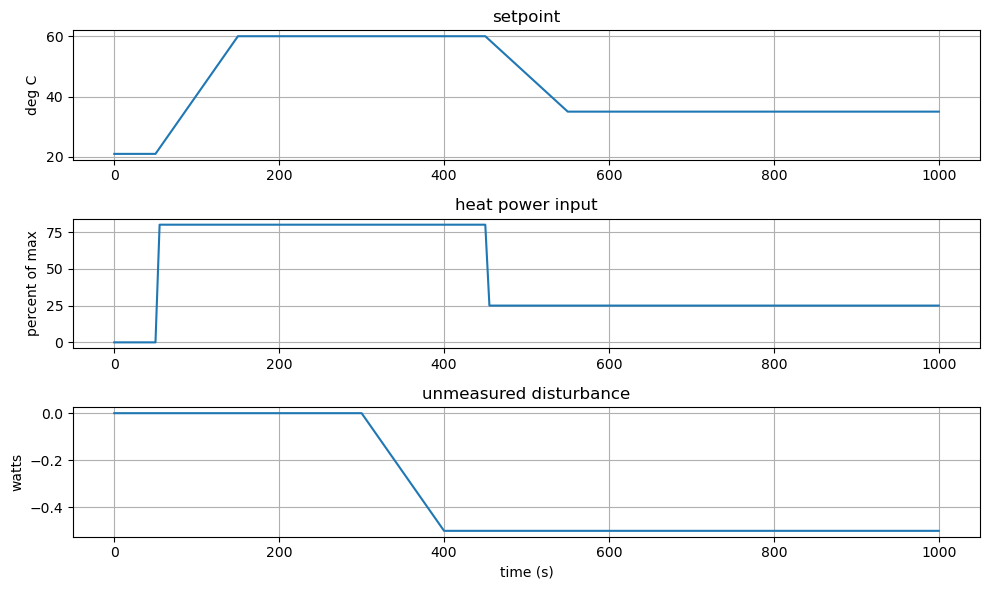

In [3]:
tclab_disturbance = interpolate.interp1d(
    [ 0, 300, 400, 9999],   # time
    [ 0, 0, -.5, -.5],      # disturbance value
    fill_value="extrapolate")   # tolerates slight exptrapolation

tclab_input = interpolate.interp1d(
    [ 0, 50, 51, 450, 451, 9999],   # time
    [ 0,  0, 80,  80,   25,   25],  # input value
    fill_value="extrapolate")   # tolerates slight exptrapolation

tclab_setpoint = interpolate.interp1d(
    [0, 50, 150, 450, 550, 9999],   # time 
    [Tamb, Tamb, 60, 60, 35, 35],   # set point value
    fill_value="extrapolate")   # tolerates slight exptrapolation`

t_sim = np.linspace(0, 1000, 201)       # create 201 time points between 0 and 1000 seconds
u_sim = tclab_input(t_sim)              # calculate input signal at time points
d_sim = tclab_disturbance(t_sim)        # calculate disturbance at time points
setpoint_sim = tclab_setpoint(t_sim)    # calculate set point at time points

plt.figure(figsize=(10,6))
plt.subplot(3, 1, 1)
plt.plot(t_sim, setpoint_sim)
plt.title('setpoint')
plt.ylabel('deg C')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t_sim, u_sim)
plt.title('heat power input')
plt.ylabel('percent of max')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t_sim, d_sim)
plt.title('unmeasured disturbance')
plt.ylabel('watts')
plt.xlabel('time (s)')
plt.grid(True)

plt.tight_layout()

### Simulate

Like we did in Lab 5, let's see how well our initial guess at a control strategy will work for us by using `simulate`.

\begin{align*}
C_p^H \frac{dT_H}{dt} & = U_a (T_{amb} - T_H) + U_b (T_S - T_H) + \alpha P u(t) + d(t)\\
C_p^S \frac{dT_S}{dt} & = - U_b (T_S - T_H) 
\end{align*}

subject to initial conditions

\begin{align*}
T_H(t_0) & = T_{amb} \\
T_S(t_0) & = T_{amb}
\end{align*}

and prior specification of inputs $u(t)$ and $d(t)$.

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

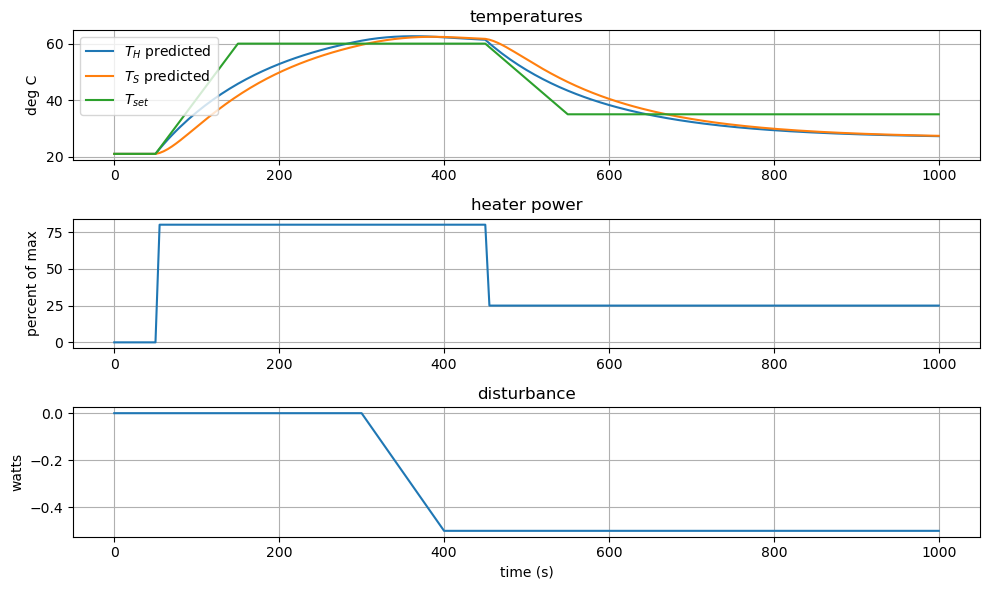

In [4]:
#Create the model in simulate mode with process inputs above
sim = TCLabPyomo('simulate',
                t_sim,
                u_sim,
                d_sim,
                setpoint_sim,
                None,
)

#Solve the model
sim.solve()

#Save Ts and Th data from the simulation for next steps
Ts_sim = sim.get_Ts()
Th_sim = sim.get_Th()

#Plot the simulation results
sim.plot()

## Coding the Observer as a Python Generator

In this exercise we create a function using a python generator to estimate state variables from a previous time horizon (h).

In [5]:
from dataclasses import dataclass

@dataclass
class ObserverResult:
    """Class for keeping track of observer results for a single iteration"""

    t: float
    Th: float
    Ts: float
    d: float

def tclab_observer(h=2, history=None):
    '''
    Function that estimates the state varibles from time horizon (h)
    using a python generator:
        h: Time horizon (default 2 seconds)
    Returns:
        t_est: time of state estimation
        Th_est: estimated heater temperature
        Ts_est: estimated sensor temperature
        d_est: estimated disturbance
    '''
    
    # Initialize the observer (_hist to store expeirmental data and _est to store state estimations)
    t_hist = [-1] 
    u_hist = [0]
    Ts_hist = [Tamb]
    
    t_est = -1
    Th_est = []
    Ts_est = []
    d_est = []


    #Create the generator: Use expeirmental data (meas) to estimate state variables (est)
    while True:
        t_meas, u_meas, Ts_meas = yield t_est, Th_est, Ts_est, d_est
  
        # Save expeirmental data to *_hist arrays
        t_hist.append(t_meas)
        u_hist.append(u_meas)
        Ts_hist.append(Ts_meas)
        
        # Extract the last h elements of each array
        t_hist = t_hist[-h:]
        u_hist = u_hist[-h:]
        Ts_hist = Ts_hist[-h:]
        
        # Create the model in observe mode with measured data
        # in the specified time horizon (h)
        # verbose = False supresses the Ipopt output
        obsv = TCLabPyomo('observe',
                 t_hist,
                 u_hist,
                 d_sim,
                 None,
                 Ts_hist,
                 verbose = False)
        
        #Solve the model
        obsv.solve()
    
        #store model results
        t_est = t_hist[-1]
        Th_est = obsv.get_Th() # This returns a numpy array. Is that intentional? Or should this return a float (last element)?
        Ts_est = obsv.get_Ts() # Returning a float would likely greatly simplify the code
        d_est = obsv.get_D()
        
        if history is not None:
            history.append(ObserverResult(t_hist.copy(), Th_est.copy(), Ts_est.copy(), d_est.copy()))
        

### Test the Observer

Test the observer using simulated data generated above as the expeirmental data input. We will also create an annimation in this notebook.

In [6]:
#Create empty arrays to store estimated state variables
t_est = []
Th_est = []
Ts_est = []
d_est = []

# Create empty array to store observer results
obs_results = []

#Create the oberver with the observer function above (set the time horizon to 5)
observer = tclab_observer(5, history=obs_results)
observer.send(None)

# Loop through simulation data and record the estimated state variables calculated by the observer
for k in range(0, len(t_sim)):
    t, Th, Ts, d = observer.send([t_sim[k], u_sim[k], Ts_sim[k]])
    t_est.append(t)
    Th_est.append(Th[-1])
    Ts_est.append(Ts[-1])
    d_est.append(d[-1])

print("number of iterations:", len(obs_results))    


number of iterations: 201


Now let's plot the results.

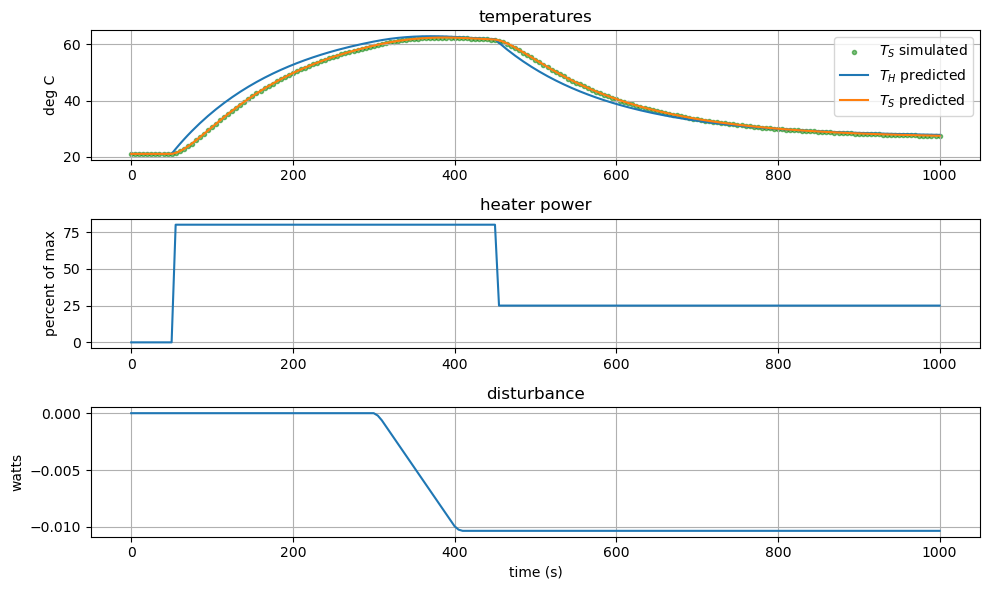

In [7]:
# create figure
plt.figure(figsize=(10,6))

# subplot 1: temperatures
plt.subplot(3, 1, 1)
plt.scatter(t_sim, Ts_sim, marker='.', label="$T_{S}$ simulated", alpha=0.5,color='green')
plt.plot(t_est, Th_est, label='$T_{H}$ predicted')
plt.plot(t_est, Ts_est, label='$T_{S}$ predicted')
# plt.plot(, self.Tset_data, label='$T_{set}$')

plt.title('temperatures')
plt.ylabel('deg C')
plt.legend()
plt.grid(True)

# subplot 2: control decision
plt.subplot(3, 1, 2)
plt.plot(t_est, u_sim)
plt.title('heater power')
plt.ylabel('percent of max')
plt.grid(True)

# subplot 3: disturbance
plt.subplot(3, 1, 3)
plt.plot(t_est, d_est)
plt.title('disturbance')
plt.ylabel('watts')
plt.xlabel('time (s)')
plt.grid(True)

plt.tight_layout()
plt.show()

### Animate the Results

Generating the animations can take up to 1 minute. You do not need to create animations in Lab 6.

In [8]:
from matplotlib import animation
from IPython.display import HTML
# Useful references:
# https://ndcbe.github.io/controls/python/A.30-Animation-in-Jupyter-Notebooks.html
# https://stackoverflow.com/questions/45091682/runtimeerror-the-init-func-must-return-a-sequence-of-artist-objects

class MPCAnimation:
    def __init__(self, setpoint_function, time_data, Ts_data, u_data=None, observer_history=None, mpc_history=None):
        self.setpoint_function = setpoint_function
        self.time_data = time_data
        self.u_data = u_data
        self.Ts_data = Ts_data
        self.observer_history = observer_history
        self.mpc_history = mpc_history
        
        # Check if only plotting the observer
        self.observer_only = mpc_history is None

        if self.observer_only and u_data is None:
            raise ValueError("u_data must be provided if mpc_history is None")
            
        if len(time_data) != len(Ts_data):
            raise ValueError("time_data and Ts_data must have the same length")
                             
        if self.observer_only and len(time_data) != len(u_data):
            raise ValueError("time_data and u_data must have the same length")

        # Create background image
        self.fig = plt.figure(figsize=(10,6))

    def _init_func(self):

        # Calculate the final time
        if not self.observer_only:
            t_final = max(self.mpc_history[-1].t)
        else:
            t_final = max(self.observer_history[-1].t)

        t_start = min(self.observer_history[0].t)

        time_sp = np.arange(t_start, t_final, 1)
        setpoint = self.setpoint_function(time_sp)

        fig = self.fig

        # subplot 1: temperatures
        ax1 = plt.subplot(3, 1, 1)

        # setpoint
        ax1.plot(time_sp, setpoint, label='$T_{set}$',color='k',linewidth=2,linestyle='-.',alpha=0.5)

        # observer results
        self.TH_est_current = ax1.plot([], [], label='$T_{H}$ estimated',color='r',linewidth=2,linestyle='-')
        self.TH_est_past = ax1.plot([], [], label='$T_{H}$ history',color='r',linewidth=2,linestyle='--',alpha=0.5)
        self.TS_est_current = ax1.plot([], [], label='$T_{S}$ estimated',color='b',linewidth=2,linestyle='-')
        self.TS_est_past = ax1.plot([], [], label='$T_{S}$ history',color='b',linewidth=2,linestyle='--',alpha=0.5)
        
        # Measurements 
        self.TS_measured = ax1.plot([], [], label='$T_{S}$ measured',color='g',marker='.',linestyle='None',alpha=0.5)

        # results for MPC
        if not self.observer_only:
            self.TH_predict = ax1.plot([], [], label='$T_{H}$ predicted',color='r',linewidth=2,linestyle=':',alpha=0.7)
            self.TS_predict = ax1.plot([], [], label='$T_{S}$ predicted',color='b',linewidth=2,linestyle=':',alpha=0.7)
            ax1.legend(ncol=4,loc='upper right')
        # results with observer only
        else:
            ax1.legend(ncol=6,loc='upper right')
        
        # finish subplot
        ax1.set_xlim(t_start, t_final)
        ax1.set_ylim(20, 115)
        ax1.set_title('temperatures')
        ax1.set_ylabel('deg C')
        ax1.grid(True)

        # subplot 2: control decision
        ax2 = plt.subplot(3, 1, 2)

        # control decision evolution with MPC
        if not self.observer_only:
            self.u_history = ax2.plot([], [], color='r',linewidth=2,linestyle='--',label='$u$ history',alpha=0.5)
            self.u_predict = ax2.plot([], [], color='r',linewidth=2,linestyle=':',label='$u$ predicted',alpha=0.7)
            ax2.legend(ncol=2,loc='upper right')
        
        # otherwise control decision is fixed
        else:
            ax2.plot(self.time_data, self.u_data, label='heater power',color='r',linewidth=2,linestyle='-')
            ax2.legend()

        ax2.set_xlim(t_start, t_final)
        ax2.set_ylim(0, 100)
        ax2.set_title('heater power')
        ax2.set_ylabel('percent of max')
        ax2.grid(True)

        # subplot 3: disturbance
        ax3 = plt.subplot(3, 1, 3)

        self.disturb_est_current = ax3.plot([],[], label='$d$ estimated',color='g',linewidth=2,linestyle='-')
        self.disturb_est_past = ax3.plot([],[], label='$d$ history',color='g',linewidth=2,linestyle='--',alpha=0.5)
        ax3.set_xlim(t_start, t_final)
        ax3.set_ylim(-1, 1)
        ax3.set_title('disturbance')
        ax3.set_ylabel('watts')
        ax3.set_xlabel('time (s)')
        ax3.legend(ncol=2,loc='lower right')
        ax3.grid(True)

        plt.tight_layout()

        self.fig = fig

        
    def _draw_frame(self, n):

        obs_results = self.observer_history
        mpc_results = self.mpc_history

        # Plot the measurement data
        self.TS_measured[0].set_data(self.time_data[:n+1], self.Ts_data[:n+1])

        # Plot the current observer results
        self.TH_est_current[0].set_data(obs_results[n].t, obs_results[n].Th)
        self.TS_est_current[0].set_data(obs_results[n].t, obs_results[n].Ts)
        self.disturb_est_current[0].set_data(obs_results[n].t, obs_results[n].d)
        
        # Grab last element of each prior rolling horizon (observer history)
        self.TH_est_past[0].set_data([x.t[-1] for x in obs_results[:n]], [x.Th[-1] for x in obs_results[:n]])
        self.TS_est_past[0].set_data([x.t[-1] for x in obs_results[:n]], [x.Ts[-1] for x in obs_results[:n]])
        self.disturb_est_past[0].set_data([x.t[-1] for x in obs_results[:n]], [x.d[-1] for x in obs_results[:n]])

        # Plot the current MPC results
        if not self.observer_only:
            # Grab last element of each prior rolling horizon (mpc history)
            self.u_history[0].set_data([x.t[0] for x in mpc_results[:n]], [x.u[0] for x in mpc_results[:n]])
            self.TH_predict[0].set_data(mpc_results[n].t, mpc_results[n].Th)

            # Plot the current MPC results
            self.TS_predict[0].set_data(mpc_results[n].t, mpc_results[n].Ts)
            self.u_predict[0].set_data(mpc_results[n].t, mpc_results[n].u)
        
    def animate(self, interval=50):
        ''' Create the animation

        Arguments:
            interval: the delay between frames in milliseconds

        '''

        # Passing this to the animation function causes the legend to get
        # created twice
        self._init_func()

        self.anim = animation.FuncAnimation(self.fig, 
                                            func = self._draw_frame, 
                                            frames=len(self.observer_history), 
                                            # init_func=self._init_func,
                                            interval=interval, 
                                            blit=False)
        
        # Unsuccesful with blit = True
        # https://stackoverflow.com/questions/56720875/matplotlib-basemap-multiple-shapes-animation-exception-list-object-has-no-att


    def show(self):
        ''' Display the animation
        '''
        
        return HTML(self.anim.to_html5_video())

    def save(self, filename):
        ''' Save the animation to a file

        Arguments:
            filename: the name of the file

        '''

        self.anim.save(filename, writer='ffmpeg', fps=30)

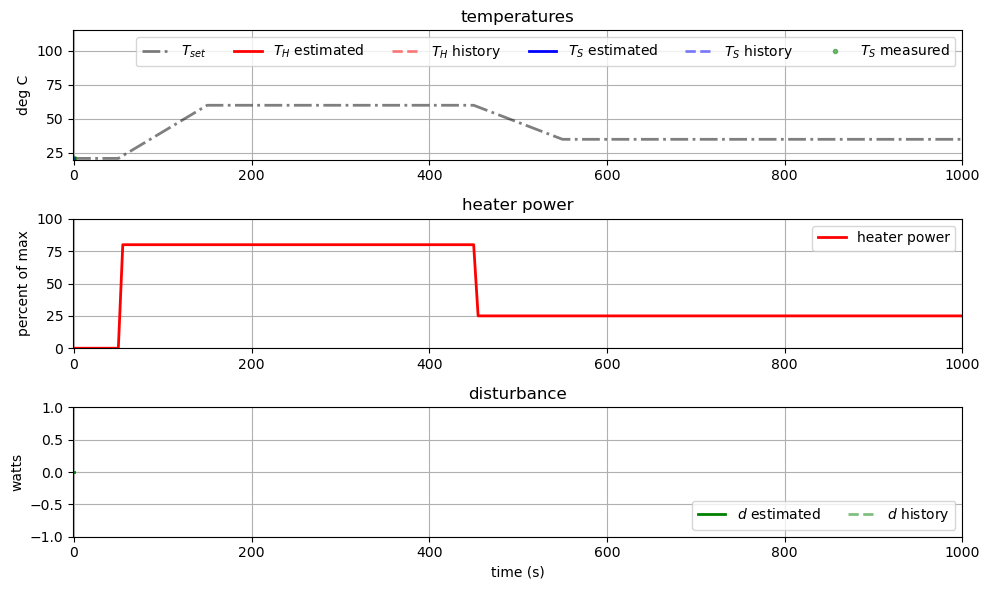

In [9]:
animation1 = MPCAnimation(tclab_setpoint, t_sim, Ts_sim, u_sim, obs_results, None)
animation1.animate()
#animation1.save('observer_simulation.mp4')
animation1.show()

## Coding the Controller as a Python Generator

Next, we will create a function using a Python generator to optimize the heater output given state estimates from the obsrver.

In [10]:
#Controller: at time step 100 (default h controller), the observer looks back 2 secs (default h observer)
# at state estimates (Th and Ts) and propagates forward to determine u

@dataclass
class MPCResult:
    """Class for keeping track of observer results for a single iteration"""

    t: float
    Th: float
    Ts: float
    u: float
    d: float

def tclab_control(set_point_func, h=100, history=None): 
    '''
    Function that at time step 100 (default h controller), the observer looks back 2 secs (default h observer)
    at state estimates (Th and Ts) and propegates forward to determine u:
        set_point_func: Function of the temperature setpoint as a function of time
        h: Time horize (default 100 seconds)
    Returns:
        u: heater output
    '''
    
    #Initialize the heater output to 0
    u = 0
    while True:
        # state estimations from the observer are used to determine the optimal heater output
        # t_est (float), Th_est (float), Ts_est (float), d_est (float) = yield u 
        t_est, Th_est, Ts_est, d_est = yield u
        
        #The optimization time horizon is the point of state estimation (t_est) + h (default 100)
        tf = t_est + h #Final time
        time = np.linspace(t_est, tf, h+1) #create an array for time 
        disturbance = np.ones(h+1) * d_est[-1] #use the last value of d_est (from the observer) to create an array for d_data
        # T_sensor = np.ones(h+1) * Ts_est[-1] #use the last value of Ts_est (from the observer) to create an array for Ts_data
        
        #Create the model in optimize mode with estimated data from the observer
        #in the specified time horizon (h)
        #verbose = False supresses the ipopt output
        opt = TCLabPyomo('optimize',
                 time,
                 None,
                 disturbance,  
                 set_point_func(time), 
                 None,
                 verbose = False) 
        
        # Set the initial conditions for the optimization model
        opt.set_initial_conditions(Th_est[-1], Ts_est[-1])

        #Solve the model
        opt.solve()

        #Store the optimal u value for t_est (first value of u output from the optimization model)
        umpc = opt.get_U()
        time = opt.get_time()

        u = umpc[0]

        # Optional: store results for animation
        if history is not None:
            history.append(MPCResult(opt.get_time(), opt.get_Th(), opt.get_Ts(), opt.get_U(), opt.get_D()))

### Test the Controller 

Test the controller using output from the obserever using simulated data from Exercise 0 as the expeirmental data input


In [11]:
#Create the oberver with the observer function (set the time horizon to 3)
observer_history = []
observer = tclab_observer(3, observer_history)
observer.send(None)


#Create the controller with the controller function above, pass the set point function from Exercise 0
mpc_history = []
controller = tclab_control(tclab_setpoint, 100, mpc_history)
controller.send(None)

#Create empty arrays to store MPC results
t_mpc = []
u_mpc = []
Th_mpc = []
Ts_mpc = []

#Loop through simulation data (Exercise 0) 
for k in range(0, len(t_sim)):
    #Estimate the state variables from the observer using simulation data
    t, Th, Ts, d = observer.send([t_sim[k], u_sim[k], Ts_sim[k]])
    # Optimize the heater ouput using the state estimations from the observer
    u = controller.send([t, Th, Ts, d])
    
    # Store optimization results
    u_mpc.append(u)
    Th_mpc.append(Th[-1])
    Ts_mpc.append(Ts[-1])



Now we will plot the final results.

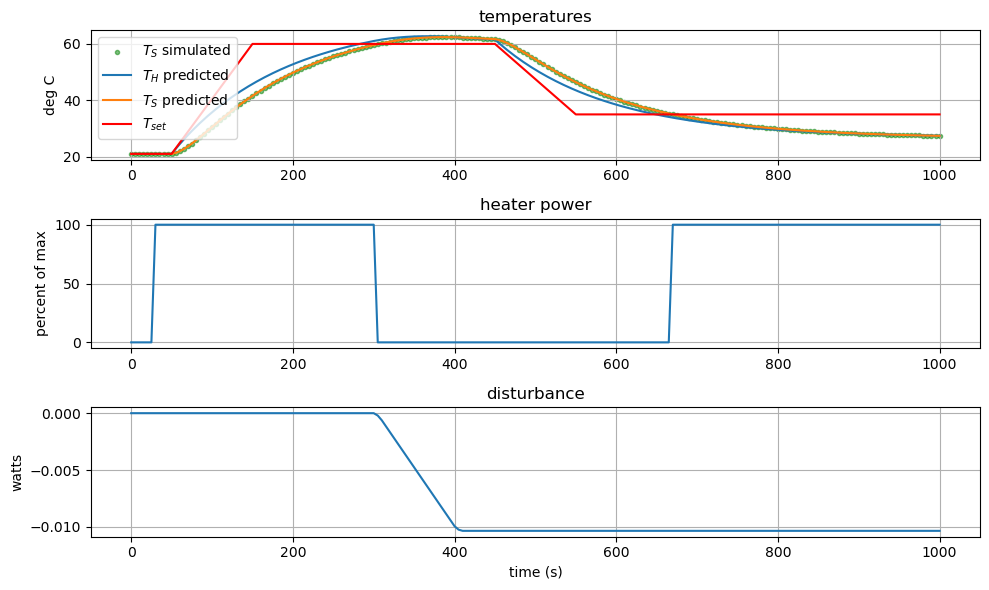

In [12]:
#Plot results
# create figure
plt.figure(figsize=(10,6))

# subplot 1: temperatures
plt.subplot(3, 1, 1)
plt.scatter(t_sim, Ts_sim, marker='.', label="$T_{S}$ simulated", alpha=0.5,color='green')
plt.plot(t_sim, Th_mpc, label='$T_{H}$ predicted')
plt.plot(t_sim, Ts_mpc, label='$T_{S}$ predicted')
plt.plot(t_sim, setpoint_sim, label='$T_{set}$', color='red')

plt.title('temperatures')
plt.ylabel('deg C')
plt.legend()
plt.grid(True)

# subplot 2: control decision
plt.subplot(3, 1, 2)
plt.plot(t_sim, u_mpc)
plt.title('heater power')
plt.ylabel('percent of max')
plt.grid(True)

# subplot 3: disturbance
plt.subplot(3, 1, 3)
plt.plot(t_est, d_est)
plt.title('disturbance')
plt.ylabel('watts')
plt.xlabel('time (s)')
plt.grid(True)

plt.tight_layout()
plt.show()

### Animate the Results

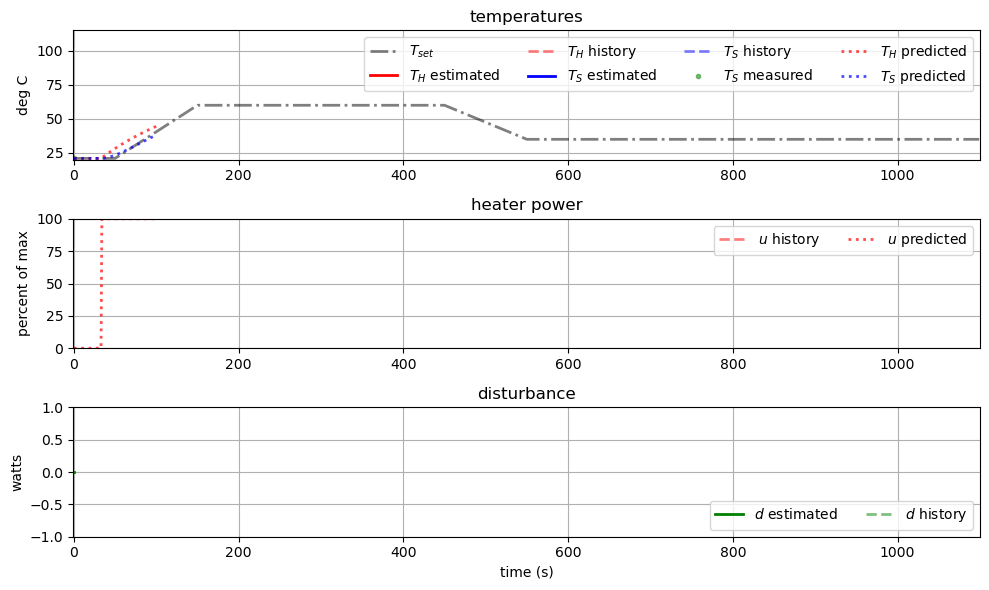

In [13]:
animation2 = MPCAnimation(tclab_setpoint, t_sim, Ts_sim, u_sim, observer_history, mpc_history)
animation2.animate()
#animation2.save('observer_control_simulation.mp4')
animation2.show()

Remember, we are "replaying" our simulation results in place of real data. Thus changing $u(t)$ has no impact on the measured data in the above annimation. This explains some of the strange behavior.

## MPC Demonstration

Now that we have all of the pieces in place, let us look at combining the observer and controller with the TCLab hardware.

### TCLab Hardware (Simulation)

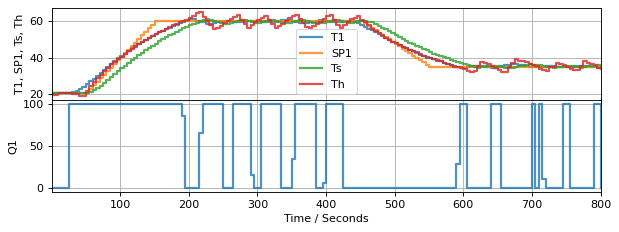

TCLab Model disconnected successfully.


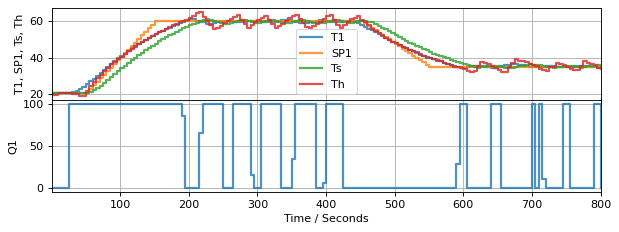

In [14]:
from tclab import setup, clock, Historian, Plotter
TCLab = setup(connected=False, speedup=20)

# create a controller instance (setpoint from above, with time horizon 600)
mpc_results2 = []
controller = tclab_control(tclab_setpoint,600, mpc_results2)
controller.send(None)

# create an model estimator (time horizon 5)
obs_results2 = []
observer = tclab_observer(5, obs_results2)
observer.send(None)

# execute the event loop
tf = 800
with TCLab() as lab:
    h = Historian([('T1', lambda: lab.T1), ('Q1', lab.Q1),
                   ('Th', lambda: Th[-1]), ('Ts', lambda: Ts[-1]),
                  ("SP1", lambda: tclab_setpoint(t))])
    p = Plotter(h, tf, layout=(("T1", "SP1", "Ts", "Th"),('Q1',)))
    U1 = 0
    lab.P1 = 200                              # set the maximum power to max default for TCLabPyomo
    for t in clock(tf, 5):                    # allow time for more calculations
        T1 = lab.T1                           # measure the sensor temperature
        t, Th, Ts, d = observer.send([t, U1, T1])  # estimate the heater temperature                 
        U1 = controller.send([t, Th, Ts, d])        # compute control action
        lab.U1 = U1                           # set manipulated variable  
        p.update(t)                           # log data

### Animate the Results

In [15]:
import pandas as pd
df = pd.DataFrame.from_records(h.log, columns=h.columns, index='Time')
df.head()

time_mpc = df.index
TS_measured_mpc = df['T1'].values

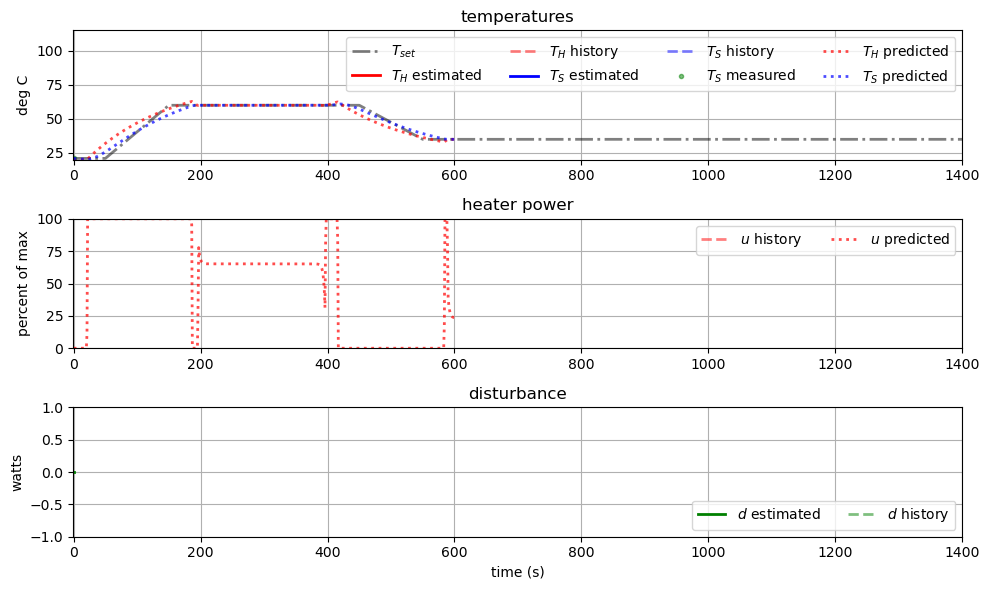

In [16]:
animation3 = MPCAnimation(tclab_setpoint, time_mpc, TS_measured_mpc, None, obs_results2, mpc_results2)
animation3.animate()
#animation3.save('observer_control_tclab.mp4')
animation3.show()

## Recommended Exercise

1. Modify the MPC implementation above to maintain the **heater** temperature at the set point. Our current implementation focuses on the sensor temperature.
2. Add a disturbance using `Q2`. How well does MPC handle an unplanned disturbance?
3. Recall this notebook using the TCLab digital twin (`connected=False`) to generate data. I suspect our Pyomo model is very close to model used by the TCLab digital twin. Adjust the model parameters to add plant/model mismatch then rerun the notebook. What happens to the MPC performance with a worse model? How bad can you make the model and still get okay controller performance? (During lecture in Spring 2024, we saw results for an "okay" model. The disturbance and $T_H$ estimates were a lot noisier.)